# 3D Nerve Surface Segmentation 

**Add Proper References Here**

**NOTICE:** This notebook assumes you are familiar layered surface detection on tubular objects introduced in the *NerveSegmentation2D* notebook. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imsave 
from skimage.io import imread
from scipy.ndimage.interpolation import map_coordinates

from qimtools import visualization, inspection, io
from slgbuilder import GraphObject,MaxflowBuilder

The data is a small stack of nerve images.

In [2]:
in_dir = 'data/'
Vol_path = os.path.join(in_dir, 'nerves3D.tiff')

# Load the data
vol = io.Volume( Vol_path )

# Convert the stack of 2D slices to a 3D volume
vol = vol.concatenate().astype(np.int32)
vol = np.transpose(vol,(1,2,0))

print(vol.shape)

(200, 200, 10)


In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


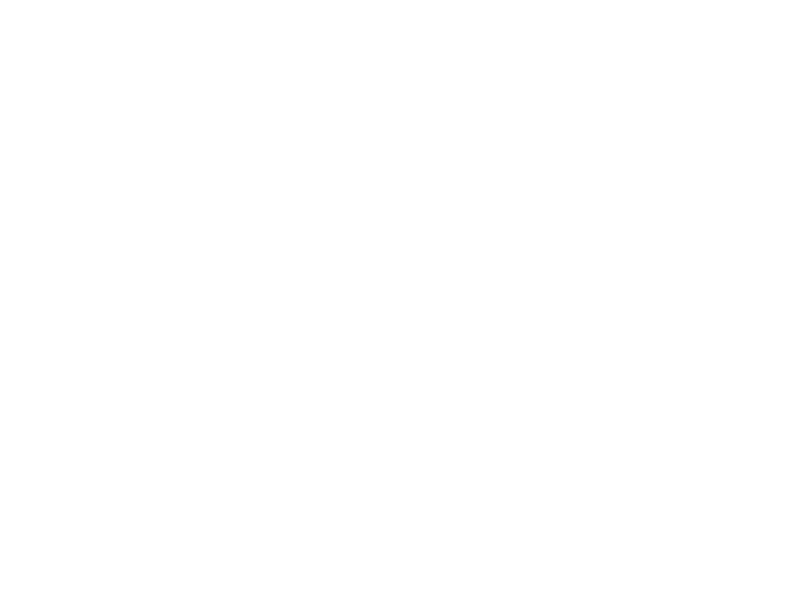

Instructions:
    Controls
    --------
        'up-arrow'    : Next slice in volume
        'down-arrow'  : Previous slice in volume
        'right-arrow' : +10 slices
        'left-arrow'  : -10 slices
        'PgUp'        : +50 slices
        'PgDown'      : -50 slices

        scroll wheel  : previous/next slice
        


In [4]:
visualization.show_vol( vol, axis=2 )

In [5]:
%matplotlib inline

The objects (nerves) in the volume have two different sizes which need to be handled differently. With small nerves marked in red an large in blue.

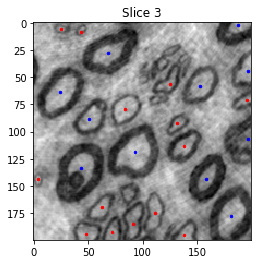

Number of objects: 25


In [6]:
# Get centers
path = in_dir+'nerveCenters.png'
centers = imread(path)[:,:,0]

centers_small = np.transpose(np.where(centers==1))
centers_large = np.transpose(np.where(centers==2))

# Show volume slice with centers.
plt.imshow(vol[...,3], cmap='gray')
plt.scatter(centers_small[..., 1], centers_small[..., 0], color='red', s=6)
plt.scatter(centers_large[..., 1], centers_large[..., 0], color='blue', s=6)
plt.title('Slice 3')
plt.show()

print(f'Number of objects: {len(centers_small)+len(centers_large)}')

As with the 2D example radial resampling is used for segmentation.

In [7]:
def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):

    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

def draw_segmentations(data, helper,layer=0):
    """Draw all segmentations for objects in the helper on top of the data."""
    
    if data.ndim != 3:
        raise ValueError('Data should be in three dimensions')
    K = (len(helper.objects)//vol.shape[-1])//2
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(data[...,layer], cmap='gray')
    plt.xlim([0, data[...,layer].shape[1]-1])
    plt.ylim([data[...,layer].shape[0]-1, 0])
    plt.title(f'Slice {layer}')

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):
        if (i >= layer*K and i < (layer+1)*K) or (i >= (vol.shape[-1]+layer)*K and i< (vol.shape[-1]+layer+1)*K):
            # Get segmentation.
            segment = helper.get_labels(obj)
    
            # Create line.
            line = np.count_nonzero(segment, axis=0)
    
            # Get actual points.
            point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
            points = obj.sample_points[point_indices]
            # Close line.
            points = np.append(points, points[:1], axis=0)
    
            # Plot points.
            plt.plot(points[..., 1], points[..., 0])
    plt.show()

## Detect layers in object
In each slice of the volume there are 25 different nerves that we would like to segment. Each nerve should be seperated into an inner and an outer nerve which can be done by using the gradient image. The segmentations are prepared by stacking `GraphObjects` of each nerver image and then segmenting each one.  

To get a better segmentation the large nerves in this example needs a larger sampling radius.

In [8]:
nerve_samples = []
outer_nerves = []
inner_nerves = []

layers = []

# For each center, create an inner and outer nerve.
for i in range(vol.shape[-1]):
    for center in centers_small:
            samples, sample_points = unfold_image(vol[...,i], center,r_max=40,angles=40,steps=30)
            nerve_samples.append(samples)
            
            # Create outer and inner nerve objects.
            diff_samples = np.diff(samples, axis=0)
            diff_sample_points = sample_points[:-1]
        
    
            outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
            inner_nerves.append(GraphObject(diff_samples, diff_sample_points))
    for center in centers_large:
            samples, sample_points = unfold_image(vol[...,i], center,r_max=60,angles=40,steps=30)
            nerve_samples.append(samples)
            
            # Create outer and inner nerve objects.
            diff_samples = np.diff(samples, axis=0)
            diff_sample_points = sample_points[:-1]
        
    
            outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
            inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

Let's detect the layers. We apply boundary cost, smoothness and containment constraints. Here we set both min_margin and max_margin constraints for our containment. Then we use maxflow to find the optimal solution.

In [9]:
helper = MaxflowBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 2371864


The segmentations are extracted from the `GraphObject`

In [10]:
# Get segmentations.
segmentations = []

# for i in range(vol.shape[0]):
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

The segmentations are visualized for each slice. But some of the segmentations are overlapping

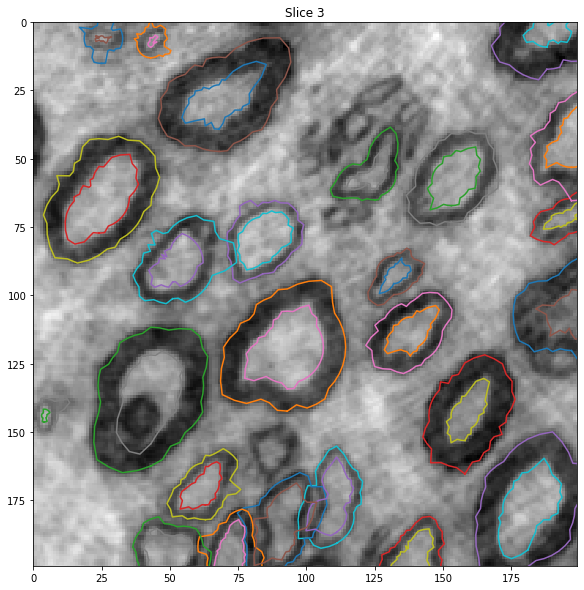

In [11]:
layer = 3 # change to view other slices
draw_segmentations(vol, helper,layer)

## Multi-object exclusion
To overcome the issue of overlapping segments, we can add exclusion contraints between all outer nerves. However, exclusion is a so-called *nonsubmodular* energy term, which means it cannot be represented as a single edge in our graph. Luckily there's an algorithm called *QPBO* (Qudratic Pseudo-Boolean Optimization) that can help us. 

QPBO creates creates a complementary graph, alongside the original graph. The complementary graph is inverted, meaning that is has the exact same edges as the original graph, except they are reversed. This means that the graph size is doubled, which makes computation slower and uses more memory. The benefit of QPBO is that we can now add nonsubmodular energies such as exclusion. 

The ```graphhelper``` module contains a ```QPBOHelper``` class, which is very similar to the ```GraphHelper``` we've been using so far. The main difference is that it has functions for adding exclusion. One of these is ```add_layered_exclusion``` which we will now use. We will be using the ```GraphObject```s created earlier.

In [12]:
from slgbuilder import QPBOBuilder

helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)
    
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

if 2*flow == twice_flow:
    print('QPBO flow is exactly twice the Maxflow flow.')
else:
    print('Something is wrong...')

Two times maximum flow/minimum energy: 4743728
QPBO flow is exactly twice the Maxflow flow.


In [13]:
# Add exclusion constraints between all pairs of outer nerves.
interval = len(outer_nerves)//vol.shape[-1]
for i in range(vol.shape[-1]):
        for j in range(len(outer_nerves)//vol.shape[-1]):
            for k in range(j + 1, len(outer_nerves)//vol.shape[-1]):
                helper.add_layered_exclusion(outer_nerves[interval*i+j], 
                                             outer_nerves[interval*i+k], margin=3)

In [14]:
twice_flow = helper.solve()
print('Two times maximum flow/minimum energy:', twice_flow)

Two times maximum flow/minimum energy: 4750444


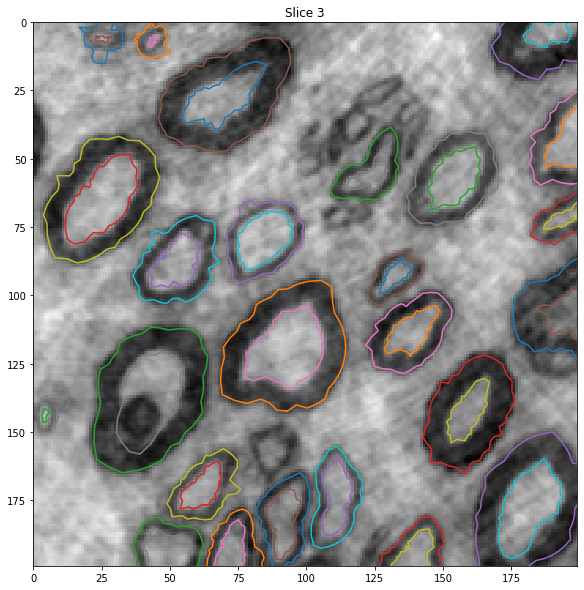

In [15]:
draw_segmentations(vol, helper,layer=3)

Which yields a much nicer segmentation